# SVM vs CNN

OVA SVESKA SE MOZE IZVRSAVATI

U ovoj svesci poredimo performanse ranije istreniranih SVM i CNN modela. 

Prvo cemo se osvrnuti na osnovne performanse:
- preciznost
- f1 ocena
- matrica konfuzije i sl.

Zatim cemo se osvrnuti na reci koje modeli ocenjuju kao najrelevantnije:
- kod SVM modela relevantnost ocenjujemo direktno preko koeficijenata
- kod CNN modela koristimo LRP


In [1]:
max_doc_len = 400

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import os
import pickle
import gensim
import nltk

In [27]:
from sklearn import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalMaxPool1D, Conv1D, Embedding, Dropout, MaxPool1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

## Ucitavanje i priprema podataka

In [6]:
test_data = datasets.fetch_20newsgroups(random_state=61, subset='test', remove=('headers'))
train_data = datasets.fetch_20newsgroups(random_state=61, remove=('headers'))
X_train = train_data.data
y_train = train_data.target
X_test = test_data.data
y_test = test_data.target
feature_names = test_data.target_names

### Priprema za CNN

In [7]:
X_train_tok = [nltk.tokenize.word_tokenize(text) for text in X_train]
X_test_tok = [nltk.tokenize.word_tokenize(text) for text in X_test] 

In [8]:
with open(os.path.join("data", "googlew2v_vocab.pickle"), "rb") as load_file:
    googlew2v_vocab = pickle.load(load_file)

In [9]:
googlew2v_index_to_key = { index : key for (key,index) in zip(list(googlew2v_vocab.keys()), range(1,len(googlew2v_vocab)+1))}

In [10]:
googlew2v_key_to_index = { googlew2v_index_to_key[index] : index for index in googlew2v_index_to_key }

In [12]:
X_train_tok_filt = [[word for word in text if word in googlew2v_key_to_index] for text in X_train_tok]
X_test_tok_filt = [[word for word in text if word in googlew2v_key_to_index] for text in X_test_tok]

In [13]:
X_google_train_idx = [[googlew2v_key_to_index[word] for word in text if word in googlew2v_key_to_index] for text in X_train_tok_filt]
X_google_test_idx = [[googlew2v_key_to_index[word] for word in text if word in googlew2v_key_to_index] for text in X_test_tok_filt]

In [14]:
X_train_google_input = pad_sequences(X_google_train_idx, maxlen=max_doc_len)
X_test_google_input = pad_sequences(X_google_test_idx, maxlen=max_doc_len)

In [16]:
y_test_cat = to_categorical(y_test)

In [17]:
def prepare_input_with0(text):
    text = nltk.tokenize.word_tokenize(text)
    text_idx = np.array([googlew2v_key_to_index[word] if word in googlew2v_key_to_index else 0 for word in text])
    text_idx_padded = pad_sequences([text_idx], maxlen=max_doc_len)[0]
    
    return np.array([text_idx_padded])

### Priprema za SVM

In [18]:
with open(os.path.join("models", "vectorizer.pickle"), "rb") as load_file:
    vectorizer = pickle.load(load_file)

In [111]:
vocabulary = vectorizer.vocabulary_
inv_vocabulary = { vocabulary[word] : word for word in vocabulary}

In [19]:
%%time
X_train_tfidf = vectorizer.transform(X_train)

CPU times: total: 17.5 s
Wall time: 17.5 s


In [20]:
%%time
X_test_tfidf = vectorizer.transform(X_test)

CPU times: total: 10.5 s
Wall time: 10.5 s


## Ucitavanje modela i njihove ocene

In [29]:
# parametri modela mogu se dobiti iz samih modela po potrebi
# (ili naci u odgovarajucim sveskama, ostavljeni su bas ti modeli)

In [21]:
with open(os.path.join("models", "svm2.model.pickle"), "rb") as load_file:
    svm = pickle.load(load_file)

In [23]:
cnn = load_model(os.path.join("models", "best_cnn.hdf5"))

In [24]:
# osnovne ocene

In [25]:
y_predicted_svm = svm.predict(X_test_tfidf)

In [37]:
y_predicted = cnn.predict(X_test_google_input)
y_predicted_cnn = np.array([yp.argmax() for yp in y_predicted])

236/236 [==============================] - 9s 39ms/step


In [44]:
print(60*"=")
print("Report for SVM: ")
print("----------\n----------")
print(metrics.classification_report(y_test, y_predicted_svm))
print(60*"=")

Report for SVM: 
----------
----------
              precision    recall  f1-score   support

           0       0.76      0.75      0.75       319
           1       0.70      0.71      0.71       389
           2       0.72      0.67      0.69       394
           3       0.65      0.69      0.67       392
           4       0.74      0.76      0.75       385
           5       0.83      0.73      0.78       395
           6       0.76      0.83      0.79       390
           7       0.87      0.85      0.86       396
           8       0.91      0.92      0.91       398
           9       0.90      0.92      0.91       397
          10       0.91      0.94      0.92       399
          11       0.88      0.89      0.89       396
          12       0.72      0.70      0.71       393
          13       0.86      0.82      0.84       396
          14       0.87      0.86      0.87       394
          15       0.75      0.88      0.81       398
          16       0.72      0.83      0.7

In [43]:
print(60*"=")
print("Report for CNN: ")
print("----------\n----------")
print(metrics.classification_report(y_test, y_predicted_cnn))
print(60*"=")

Report for CNN: 
----------
----------
              precision    recall  f1-score   support

           0       0.58      0.61      0.59       319
           1       0.75      0.69      0.72       389
           2       0.65      0.73      0.69       394
           3       0.65      0.71      0.68       392
           4       0.74      0.74      0.74       385
           5       0.80      0.69      0.74       395
           6       0.79      0.83      0.81       390
           7       0.85      0.84      0.85       396
           8       0.93      0.89      0.91       398
           9       0.89      0.93      0.91       397
          10       0.94      0.96      0.95       399
          11       0.85      0.79      0.82       396
          12       0.66      0.65      0.65       393
          13       0.83      0.85      0.84       396
          14       0.80      0.84      0.82       394
          15       0.72      0.88      0.79       398
          16       0.64      0.76      0.6

Primecujemo da SVM model ima bolje ocene na test skupu. <br>
Ako je verovati clanku po kojem je radjen ovaj rad, CNN moze da dogura do 80.19% test_acc, dok SVM do 80.10%.
SVM smo postigli i vecu tacnost na vecem vokabularu, dok kod CNN to nismo uspeli.

Svakako, CNN je namenjen za vece kolicine podataka, tada premasuje performanse SVM-a.

Pogledajmo sada matrice konfuzije (dijagonale postavimo na 0 zbog preglednosti):

In [67]:
def plot_confusion_matrix(model, y_predicted):
    conf_matrix = metrics.confusion_matrix(y_test, y_predicted)
    print(conf_matrix, "\n\n\n\n")
    
    matrix_to_plot = np.fill_diagonal(conf_matrix, 0.0)
    
    plt.figure(figsize=(12,12))

    plt.xticks(ticks=range(len(feature_names)), labels=feature_names, rotation=90)
    plt.yticks(ticks=range(len(feature_names)), labels=feature_names)

    plt.title(f"Confusion matrix for {type(model)} (diagonal is 0)")
    print(conf_matrix.shape)
    plt.imshow(conf_matrix)
    plt.colorbar()

    plt.show()

[[238   2   0   0   1   0   2   0   0   0   2   1   1   4   7  28   2   3
    1  27]
 [  2 277  21  10  10  21   9   1   2   6   0   8  11   1   3   1   0   3
    2   1]
 [  0  18 263  32  19  13   6   4   0   2   4   3   8   0   5   4   0   2
    3   8]
 [  0  14  26 271  26   6  16   2   2   0   0   2  20   4   2   0   0   0
    1   0]
 [  0   8   7  33 291   3  12   3   1   2   3   0  16   1   1   3   1   0
    0   0]
 [  0  39  24  10   6 290   4   2   1   0   2   1   5   0   2   3   2   0
    0   4]
 [  0   5   2  11  15   1 325   4   4   4   6   3   7   1   1   0   0   0
    0   1]
 [  0   4   4   4   2   0  10 337  10   3   1   0  12   1   0   0   2   0
    2   4]
 [  1   0   0   0   2   1   4  16 365   2   0   0   2   3   1   0   0   0
    1   0]
 [  1   0   0   1   1   0   4   0   2 364  13   0   1   3   1   3   0   0
    3   0]
 [  1   3   0   0   2   0   1   0   0   8 376   0   0   2   1   2   2   0
    1   0]
 [  0   3   2   3   5   1   5   1   4   1   0 353   5   1   2   2

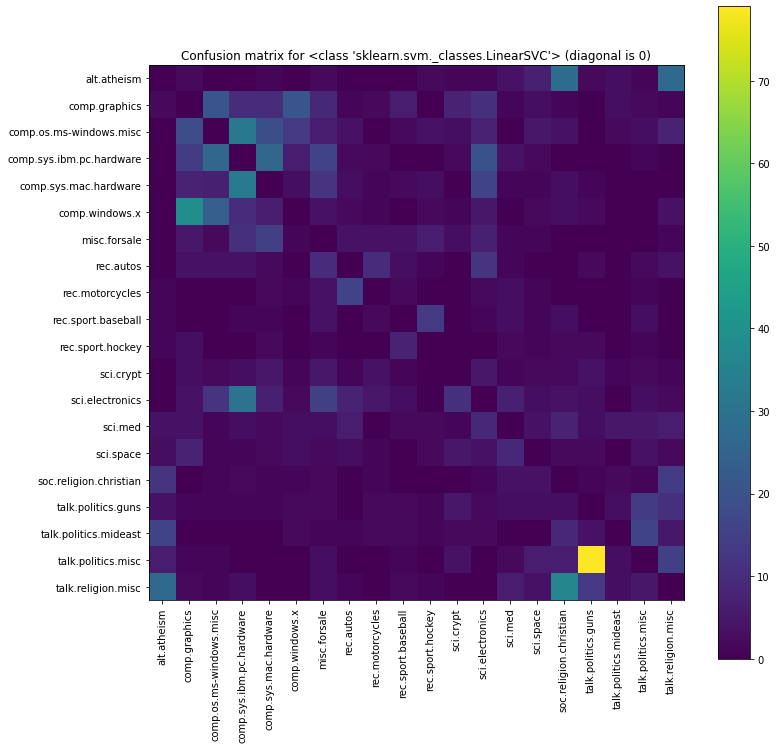

In [68]:
plot_confusion_matrix(svm, y_predicted_svm)

[[193   0   2   1   0   0   3   1   1   2   1   2   1   7  10  51   7   9
    6  22]
 [  2 269  16  18  11  28   5   0   0   1   3  11  13   2   3   5   0   1
    0   1]
 [  5  15 287  32  13  21   6   1   0   1   2   1   0   4   3   1   0   0
    1   1]
 [  0   6  33 280  23   3  15   0   2   0   0   1  25   3   1   0   0   0
    0   0]
 [  0   9  22  34 285   2   9   0   0   0   0   3  17   0   2   0   0   0
    1   1]
 [  1  28  44  13   9 271  12   1   0   2   3   2   3   0   5   0   1   0
    0   0]
 [  0   3   3  19  16   0 325   7   2   4   0   0   7   1   1   0   1   0
    1   0]
 [  1   2   2   2   1   0  10 333  11   1   0   0  18   4   4   0   3   1
    2   1]
 [  2   0   1   0   0   0   3  23 353   3   1   0   3   2   2   1   3   1
    0   0]
 [  3   1   3   0   0   0   1   0   0 370   8   1   0   4   0   3   0   1
    2   0]
 [  0   0   0   0   0   0   1   0   0  10 384   1   1   2   0   0   0   0
    0   0]
 [  4   4   4   2   3   4   3   0   0   2   0 311  18   4   3   0

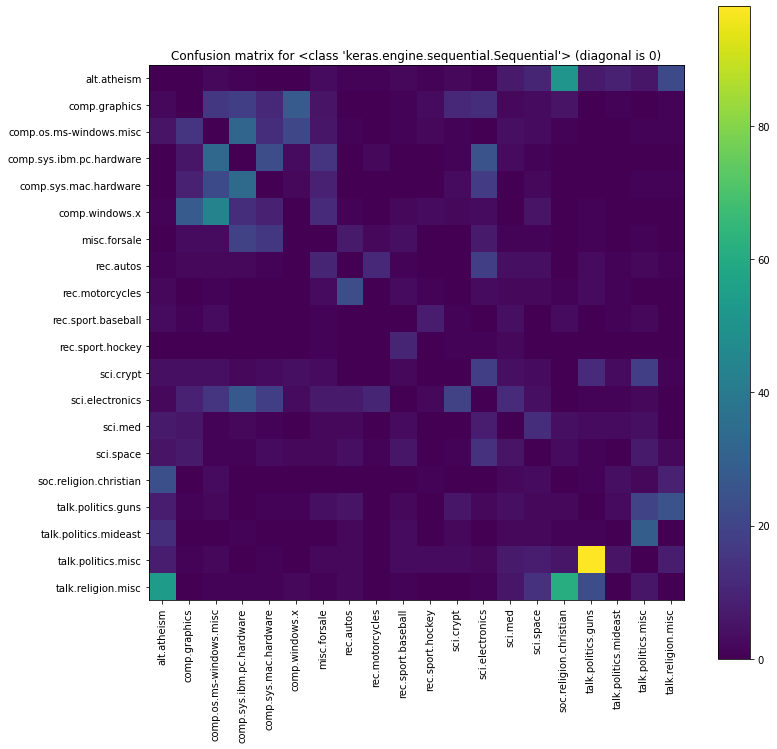

In [69]:
plot_confusion_matrix(cnn, y_predicted_cnn)

Primecujemo da klasifikatori daju slicne matrice konfuzije. <br> 
CNN npr. vise mesa soc.religion.christian sa alt.atheism itd.

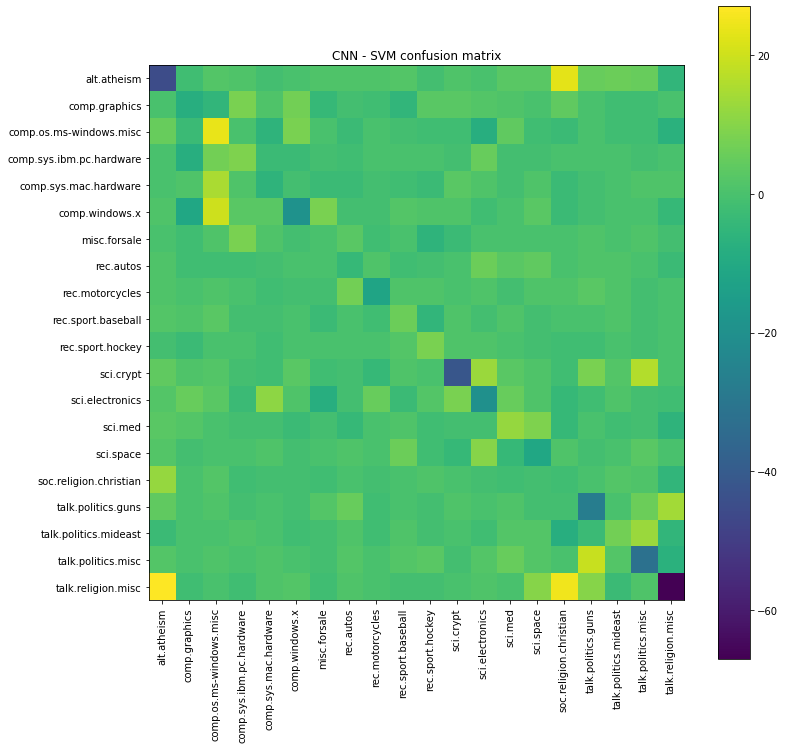

In [326]:
# sta koja klasa bolje pronalazi, a sta vise mesa (u odnosu na drugu) mozemo vizualizovati kao razliku matrica konfuzije
# CNN - SVM 
# negativne vrednosti u korist SVM, pozitivne u korist CNN

#print(metrics.confusion_matrix(y_test, y_predicted_cnn) - metrics.confusion_matrix(y_test, y_predicted_svm))

matrix_to_plot = metrics.confusion_matrix(y_test, y_predicted_cnn) - metrics.confusion_matrix(y_test, y_predicted_svm)
    
plt.figure(figsize=(12,12))

plt.xticks(ticks=range(len(feature_names)), labels=feature_names, rotation=90)
plt.yticks(ticks=range(len(feature_names)), labels=feature_names)

plt.title("CNN - SVM confusion matrix")
plt.imshow(matrix_to_plot)
plt.colorbar()

plt.show()

# Uporedjivanje relevantnih reci koje modeli pronalaze

In [79]:
# funkcije za LRP

In [80]:
def relprop_dense(wb, aj, ak, F, Rk, eps=0.01, rho=lambda x: x):
    # GORNJI SLOJ (onaj cije R imamo, koji predaje dalje)
    # DONJI SLOJ (onaj cije R racunamo)
    # w - tezine (w0jk - j donji sloj, k gornji sloj ), w1j su bias (b) - dim=(2,m,n) 
    # aj - aktivacije donjeg sloja (na slici gore - xj)- dim=(m)
    # ak - aktivacije gornjeg sloja (na slici gore - xk)
    # R - relevantnosti gornjeg sloja - dim=(n) 
    # F - sirina filtera
    
    w = wb[0]
    b = wb[1]
    
    n = len(Rk)    
    m = len(aj)
    
    zjk = np.array([[ aj[j]*w[j][k] + (1/F)*(b[k] + eps*np.sign(ak[k])) for k in range(n)] for j in range(m)])
    
    R = [np.sum(np.array([zjk[j][k]/np.sum(zjk[:, k])*Rk[k] for k in range(n)]))  for j in range(m)]
    
    return R
    


In [81]:
def relprop_maxpool(X, Rj):
    #winner-take-all
    
    Rm = np.zeros(X.shape)
    for i in range(X.shape[1]):
        winner = np.argmax(X[:,i])
        Rm[winner][i] = Rj[i]
        
    return Rm

In [82]:
# Pravilo za konvoluciju adaptirano iz formule gore

def relprop_convolution2(xit, xjt, wb, window_size, F, H, D, Rjt, eps=0.01):
     #x je word2vec
     #wb je tenzor tezina konvolucije (i bias-a)
     #F broj filtera
     #H je maksimalna duzina dokumenta
     #D je velicina word2vec vektora
     #Rjt su prethodne relevantnosti
    
    #TAU_RANGE = H - window_size + 1
    tau = window_size
    
    xit = np.transpose(xit)
    xjt = np.transpose(xjt)
    Rjt = np.transpose(Rjt)
    
    
    w = wb[0]
    b = wb[1] 
    
    Rit = np.zeros((D, H))
    
    
    # Prepravimo malo (deluje smislenije)
    hd = 1/(tau*D)
    
    zijt = np.zeros((D, F, H))
    
    zero_words = np.array([np.count_nonzero(xit[:,t]) for t in range(H)])
    
    # POTREBNO PUNO ODSECANJA (if - continueo)
    # nacelno se jako dugo izvrsava, 4tvorostruka petlja, slozene operacije nad visedimenzionim nizovima...
    # trebalo bi da se izvrsi za nekoliko sekundi do nekoliko desetina sekundi sa ovim modifikacijama
    
    # koliko ukupno Rjt predaje
    rjt_sum = np.zeros((F,H-tau))
    
    
    
    for j in range(F):
        #print(j)
        for t in range(H-tau):
            #print(j, t)
            rjt_sum[j][t] = (w[:,:,j].transpose()*xit[:, t:t+tau]).sum() + b[j] + eps*np.sign(xjt[j][t])
            
    for s in range(tau):
        for t in range(H-tau+s):
            #print(t)
            if(zero_words[t]==0):
                continue
            for j in range(F):
                if Rjt[j][t-s] == 0:
                    continue
                for i in range(D):
                    Rit[i][t] += ((xit[i][t]*w[s][i][j] + hd*(b[j] + eps*np.sign(xjt[j][t-s])))/rjt_sum[j][t-s])*Rjt[j][t-s]
            
                    
    return Rit
            
    
    
    

In [83]:
# Konacni LRP koji propagira R od vrha mreze (izlaza) do dna (ulaza) 
# koristeci ranije implementirane funkcije

def LRP(model, inp, cat, eps=0.01):
    F = model.layers[2].output_shape[2]
    H = model.input_shape[1]
    D = model.layers[0].output_shape[2]
    
    
    window_size = H - model.layers[2].output_shape[1] + 1
    
    print(window_size)
    
    wb_conv_to_emb = model.layers[2].get_weights()
    wb_dense_to_end = model.layers[-1].get_weights()
    activation_conv = backend.function([model.layers[0].input], [model.layers[2].output])
    activation_dense = backend.function([model.layers[0].input], [model.layers[3].output])
    activation_end = backend.function([model.layers[0].input], [model.layers[-1].output])
    
    Rk = np.zeros(20)
    Rk[cat] = activation_end(inp)[0][0][cat]
    
    Rj = relprop_dense(wb_dense_to_end, activation_dense(inp)[0][0], activation_end(inp)[0][0], F, Rk, eps=eps)
    
    Rp = relprop_maxpool(activation_conv(inp)[0][0], Rj)
    
    Ri = relprop_convolution2(model.layers[0].get_weights()[0][inp][0], activation_conv(inp)[0][0], wb_conv_to_emb, window_size=window_size, F=F, H=H, D=D, Rjt=Rp, eps=eps)
    
    return Ri

In [251]:
def plot_top5(top5, bot5, cat):
    plt.figure(figsize=(8,8))
    
    plt.xticks(rotation=90)
    X = np.hstack([np.array([word for word in bot5]), np.array([word for word in list(top5.keys())[::-1]])])
    y = np.hstack([np.array([bot5[word] for word in bot5]), np.array([top5[word] for word in list(top5.keys())[::-1]])])
    
    plt.title(feature_names[cat])
    plt.bar(X,y)
    plt.show()

In [84]:
def plot_relevance(R, words, num_rows=10):
    Rtoplot = R.reshape(40, 10)[-num_rows:]
    wtoplot = words.reshape(40,10)[-num_rows:]
    
    plt.figure(figsize=(24,15))

    im = plt.imshow(Rtoplot[-num_rows:], cmap='coolwarm')

    plt.xticks([])
    plt.yticks([])

    plt.colorbar()

    anot = wtoplot[-num_rows:]
    for i in range(anot.shape[0]):
        for j in range(anot.shape[1]):
            im.axes.text(j, i, anot[i, j], ha='center')
    
    
    

In [258]:
def show_relevance_cnn(text, model, epsilon=0.01):
    if len(text) < 1000:
        print(text)
        
    # pripremamo tekst (prebacujemo ga u indeksnu reprezentaciju - rec u indeks)
    text_input = prepare_input_with0(text)
    
    prediction = model.predict([text_input])[0]
    # predvidjamo kategoriju
    cat = np.argmax(prediction)
    # koliko je model siguran
    certainty = prediction.max()
    
    print("-----------------")
    print("Predicted category: ", feature_names[cat])
    print("with certainty of: ", certainty)
    print("-----------------")
    
    # odredjujemo inicijalne relevantnosti (rasporedjene po vektorima reci)
    R = LRP(model, text_input, cat, epsilon)
    
    # sumiramo ih da dobijemo relevantnost svake reci
    relevances = R.transpose().sum(axis=1)
    
    # skaliramo relevantnosti
    
    relevances_scaled = relevances#(relevances - relevances.mean())/relevances.std()
    
    # sortiramo reci po relevantnosti
    rel_sorted = np.argsort(relevances_scaled)
    
    
    # prebacimo tekst u listu reci
    words = np.array([googlew2v_index_to_key[index] if index > 0 else "*" for index in text_input[0]])
    
    # Ovo je ako hocemo da ispisemo i tokene koji se ne javljaju u trening skupu
    # mogu biti dugacki, te lose uticati na izgled, pa cemo ovo izbeci
    
    #tokenized_text = np.array(vectorizer.tokenizer(text)) 
    #words = 400*["_"]
    #for i in range(max(0,400-len(tokenized_text)), 400):
    #    words[i] = tokenized_text[i - 400 + len(tokenized_text)]
        # obelezavamo "nove reci" zvezdicom * (one koje nismo uhvatili u treningu)
    #    words[i] += "*" if tokenized_text[i - 400 + len(tokenized_text)] not in cbow_key_to_index else ""
    #words = np.array(words)
    
    
    # ispisemo po 5 najuticajnih reci (5 pozitivnih i 5 negativnih)
    
    top5 = dict()
    bot5 = dict()
    indices = rel_sorted
    
    for i in indices[::-1]:
        top = words[i]
        if top in top5:
            continue
        top5[top] = relevances[i]
        if len(top5) == 5:
            break
    
    for i in indices:
        bot = words[i]
        if bot in bot5:
            continue
        bot5[bot] = relevances[i]
        if len(bot5) == 5:
            break
    
    print("5 most posive words: ")
    for i in range(1,6):
        print(f"[{words[rel_sorted][-i]}]", " with score: ", relevances_scaled[rel_sorted[-i]])
        
    print("5 most negative words: ")
    for i in range(5):
        print(f"[{words[rel_sorted][i]}]", " with score: ", relevances_scaled[rel_sorted[i]])
        
    plot_top5(top5, bot5, cat)
        
    # iscrtamo heatmap-u poslednjih 10*num_rows reci teksta (poslednjih zbog prepadding-a)
    
    
    plot_relevance(relevances_scaled, words, num_rows=15)
    

1/1 [==============================] - 0s 15ms/step
-----------------
Predicted category:  rec.sport.hockey
with certainty of:  0.999977
-----------------
2
5 most posive words: 
[Canadiens]  with score:  0.5606527850081602
[Habs]  with score:  0.3212965484519762
[puck]  with score:  0.23673075837465252
[playoff]  with score:  0.22793606599428226
[won]  with score:  0.03986890525472963
5 most negative words: 
[Gatorade]  with score:  -0.042682452165930244
[bottle]  with score:  -0.03393886447281843
[penalty]  with score:  -0.033670142113814285
[pasted]  with score:  -0.03243798586480964
[Chelios]  with score:  -0.025875854703272617


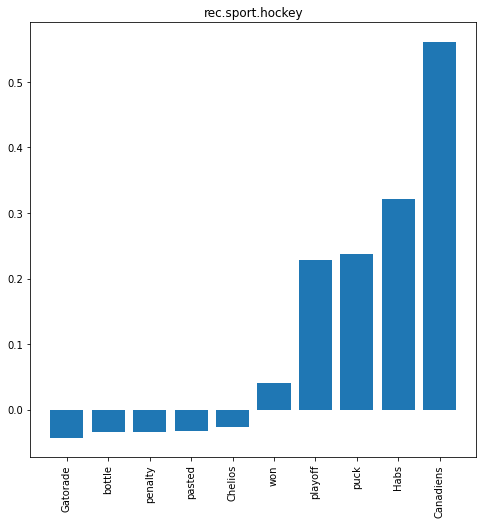

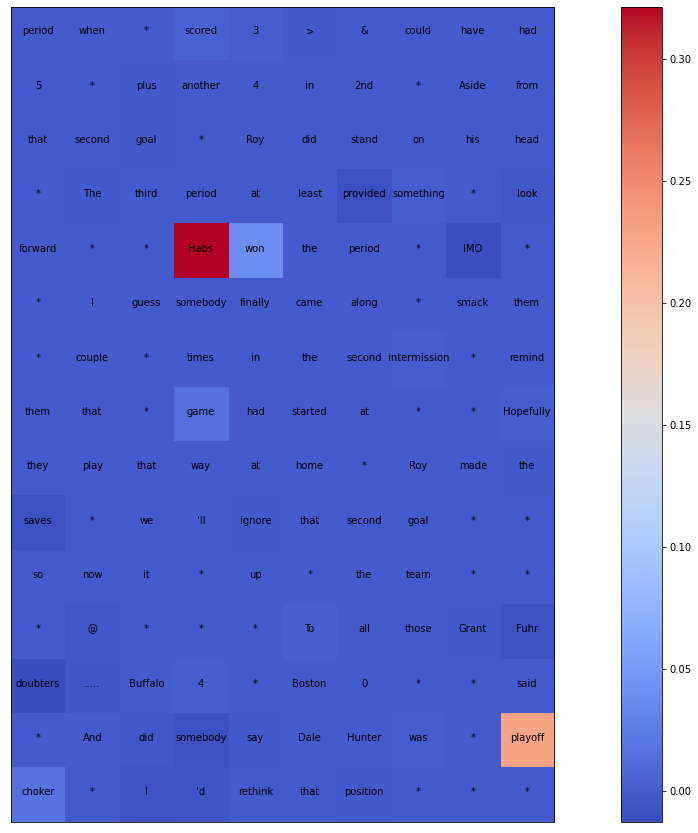

In [259]:
show_relevance_cnn(X_test[17], cnn)

### Funkcija za SVM

In [104]:
def relevances_svm(text, category, model):
    text_tfidf = vectorizer.transform([text]).toarray()[0]
    D = text_tfidf.nonzero()[0].shape[0]
    relev = []
    coefs = model.coef_[category]
    b = model.intercept_[category]
    
    text = vectorizer.tokenizer(text)
    
    for word in text:
        if word not in vectorizer.vocabulary_:
            relev.append(0)
        else:
            word_index = vectorizer.vocabulary_[word]
            relev.append(coefs[word_index] + b/D)
        
    return relev

In [295]:
def show_relevance_svm(text, model):
    text_tok = nltk.tokenize.word_tokenize(text)
    
    text_idx = np.array([vocabulary[word] if word in vocabulary else -1 for word in text ])
    
    if len(text) < 1000:
        print(text)
        
    # pripremamo tekst (prebacujemo ga u indeksnu reprezentaciju - rec u indeks)
    text_input = vectorizer.transform([text]).toarray()
    
    # predvidjamo kategoriju
    cat = model.predict(text_input)[0]

    
    print("-----------------")
    print("Predicted category: ", feature_names[cat])
    print("-----------------")
    
    # odredjujemo relevantnosti u zavisnosti od kategorije
    D = len(text_idx[text_idx >=0])
        
    relevance = np.array([ (model.coef_[cat][vocabulary[word]] + model.intercept_[cat]/D) if word in vocabulary else 0 for word in text_tok])
    
    indices = relevance.argsort()
    
    words = np.array(text_tok)
    
    top5 = dict()
    bot5 = dict()

    for i in indices[::-1]:
        top = words[i]
        if top in top5:
            continue
        top5[top] = relevance[i]
        if len(top5) == 5:
            break
    
    for i in indices:
        bot = words[i]
        if bot in bot5:
            continue
        bot5[bot] = relevance[i]
        if len(bot5) == 5:
            break
            
    
    
    # ispisemo po 5 najuticajnih reci (5 pozitivnih i 5 negativnih)
    print("5 most posive words: ")
    for item in top5.items():
        print(item[0], ": ", item[1])
    print(40*"-")
    for item in list(bot5.items())[::-1]:
        print(item[0], ": ", item[1])
        
    plot_top5(top5, bot5, cat)
    
    if len(words) < 400:
        words_padded = 400*["*"]
        relevance_padded = np.zeros(400)
        for i in range(len(words)):
            words_padded[400-len(words)+i] = words[i]
            relevance_padded[400-len(words)+i] = relevance[i]
        plot_relevance(relevance_padded, np.array(words_padded), num_rows=15)
    else:  
        plot_relevance(relevance[:400], np.array(words[:400]), num_rows=15)
    
    

---

-----------------
Predicted category:  sci.med
-----------------
5 most posive words: 
medical :  2.289394695339313
infection :  1.1844651518821248
resistant :  1.0397267775344645
literature :  1.0245927078912327
might :  0.82383847851961
----------------------------------------
have :  -0.51209555240607
engineering :  -0.5141446558919586
the :  -0.6063931048581236
those :  -0.6090882983760055
writes :  -0.7726268911750099


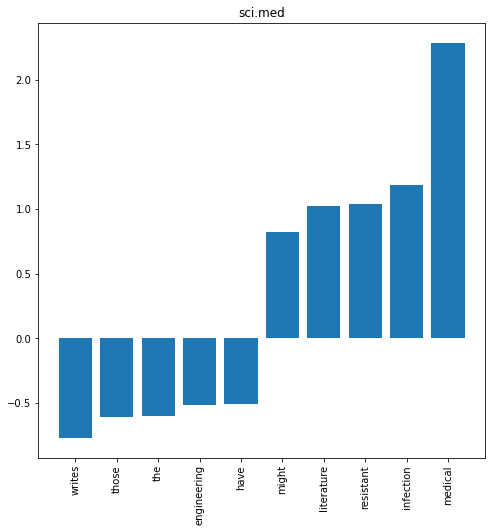

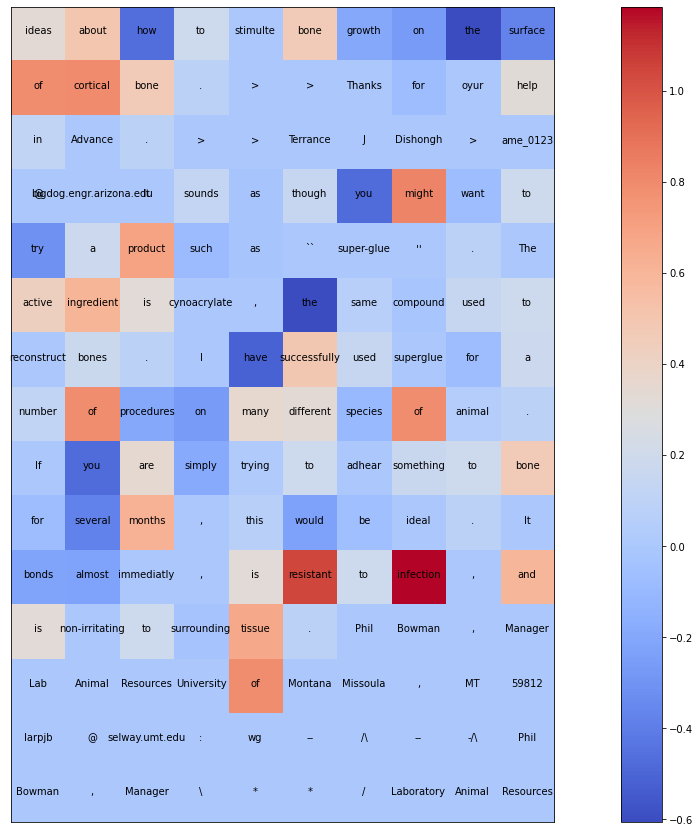

In [296]:
show_relevance_svm(X_test[777], svm)

1/1 [==============================] - 0s 16ms/step
-----------------
Predicted category:  sci.med
with certainty of:  0.9630188
-----------------
2
5 most posive words: 
[infection]  with score:  0.7384519832825504
[cortical]  with score:  0.5339777411799153
[vivo]  with score:  0.28146423880661925
[bone]  with score:  0.11730254980448243
[Laboratory]  with score:  0.09886644127026274
5 most negative words: 
[immediatly]  with score:  -0.17489464585823694
[bonds]  with score:  -0.12394424747983415
[gages]  with score:  -0.12280482904041735
[Resources]  with score:  -0.1056611344208227
[gages]  with score:  -0.08291572386060762


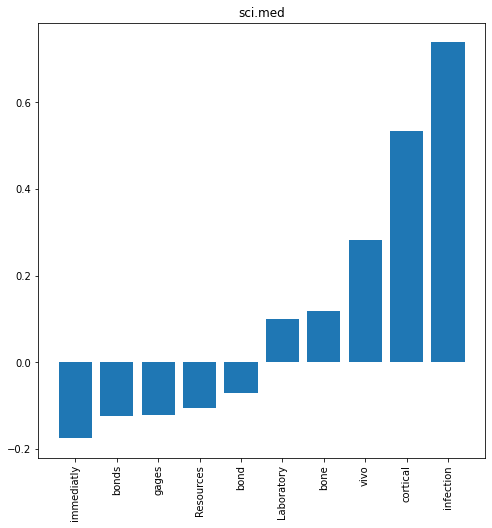

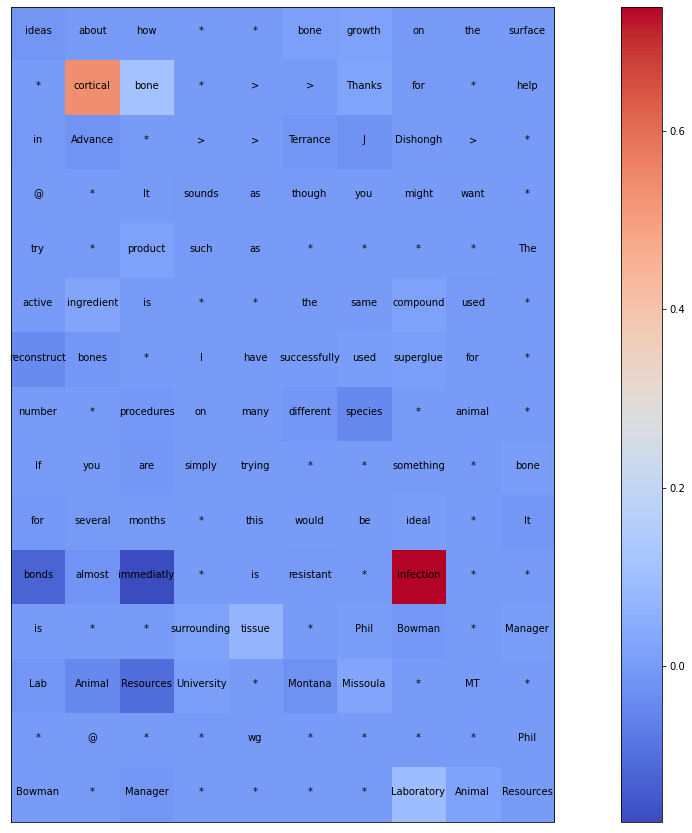

In [267]:
show_relevance_cnn(X_test[777], cnn)

In [322]:
X_test=np.array(X_test)

In [323]:
example2 = X_test[y_test==14][13]

The most current orbital elements from the NORAD two-line element sets are
carried on the Celestial BBS, (513) 427-0674, and are updated daily (when
possible).  Documentation and tracking software are also available on this
system.  As a service to the satellite user community, the most current
elements for the current shuttle mission are provided below.  The Celestial
BBS may be accessed 24 hours/day at 300, 1200, 2400, 4800, or 9600 bps using
8 data bits, 1 stop bit, no parity.

Element sets (also updated daily), shuttle elements, and some documentation
and software are also available via anonymous ftp from archive.afit.af.mil
(129.92.1.66) in the directory pub/space.

STS 55     
1 22640U 93 27  A 93119.24999999  .00041555  00000-0  12437-3 0    90
2 22640  28.4657 249.3697 0008512 260.9747 152.1416 15.90732913   425
-- 
Dr TS Kelso                           Assistant Professor of Space Operations
tkelso@afit.af.mil                    Air Force Institute of Technology

-------------

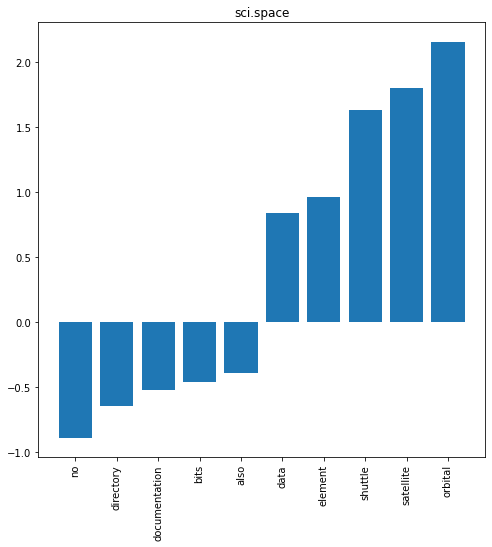

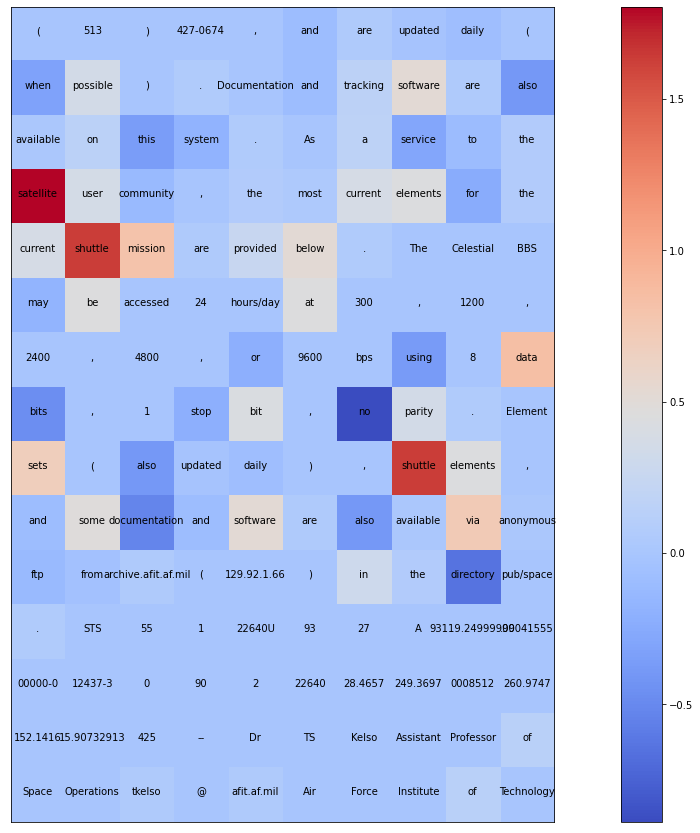

In [325]:
show_relevance_svm(example2, svm)

The most current orbital elements from the NORAD two-line element sets are
carried on the Celestial BBS, (513) 427-0674, and are updated daily (when
possible).  Documentation and tracking software are also available on this
system.  As a service to the satellite user community, the most current
elements for the current shuttle mission are provided below.  The Celestial
BBS may be accessed 24 hours/day at 300, 1200, 2400, 4800, or 9600 bps using
8 data bits, 1 stop bit, no parity.

Element sets (also updated daily), shuttle elements, and some documentation
and software are also available via anonymous ftp from archive.afit.af.mil
(129.92.1.66) in the directory pub/space.

STS 55     
1 22640U 93 27  A 93119.24999999  .00041555  00000-0  12437-3 0    90
2 22640  28.4657 249.3697 0008512 260.9747 152.1416 15.90732913   425
-- 
Dr TS Kelso                           Assistant Professor of Space Operations
tkelso@afit.af.mil                    Air Force Institute of Technology

1/1 [========

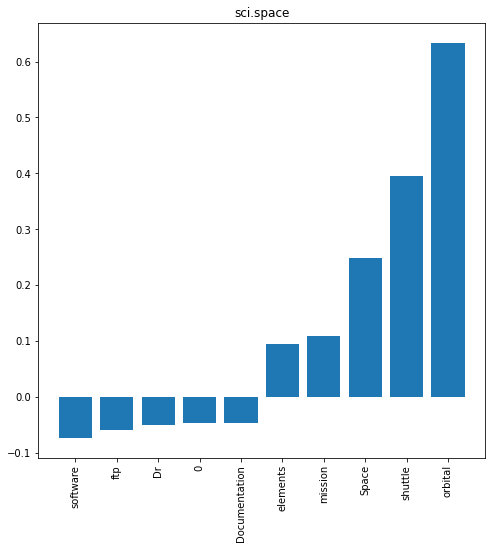

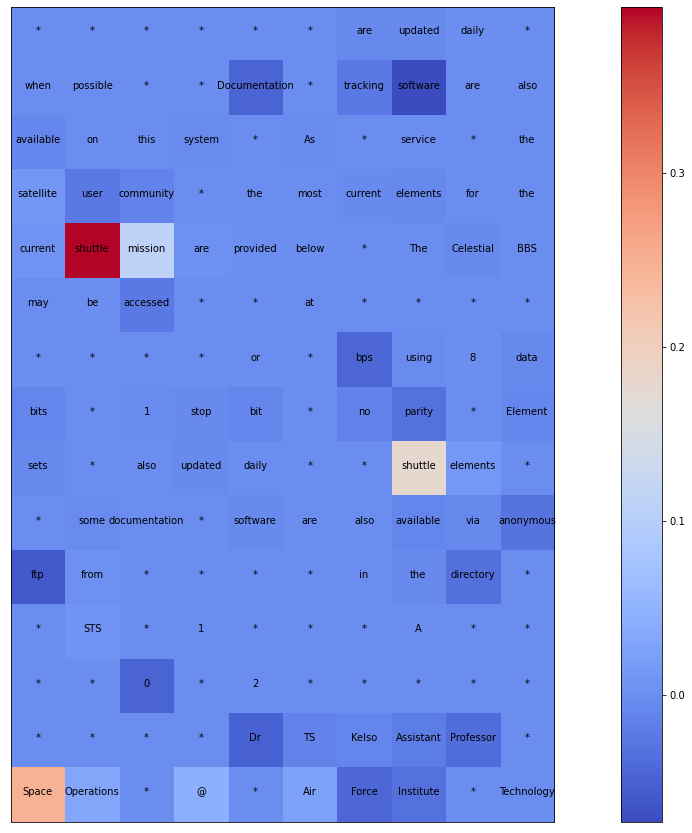

In [324]:
show_relevance_cnn(example2, cnn)

Iako su obe klasifikacije tacne, primecujemo nekoliko razlika:
1. Kljucne reci (najpozitivnije i najnegativnije) se donekle razlikuju (i iste reci nemaju jednak znacaj u oba modela)
2. Heatmap **SVM** modela je **sarenolik**, dok se kod **CNN** **jasno isticu samo kljucne reci** **(zahvaljujuci *MaxPooling*-u u CNN arhitekturi!)** 
3. Ista rec u **SVM** modela uvek ima isti doprinos, dok kod **CNN** modela to zavisi od **konteksta** (obratiti paznju na rec *bone* u primeru gore)
4. *stopwords* kod **SVM** igraju donekle znacajnu ulogu (pogotovo u negativnom smislu), dok kod **CNN** skoro uopste nisu prisutne u smislu relevantnosti

In [327]:
# igrati se dalje sa primerima, moze i neki tekst koji nije iz trening ili test skupa...